In [1]:
from db import attach_duckdb, duckdb_to_df, load_sql

attach_duckdb()

# SQL Query targeting the derived tables in the remote_mimic database
query = load_sql("tf-cohort.sql")
df = duckdb_to_df(query)

# --- PRE-PROCESSING START ---

# 1. Fill Severity Scores with 0
# Logic: If a score is missing, we assume the patient did not present conditions 
# severe enough to trigger that specific calculation (or had no comorbidities).
score_cols = ['charlson_index', 'lods', 'oasis', 'sapsii', 'sofa_max_24h']
cols_to_fill_zero = [col for col in score_cols if col in df.columns]
df[cols_to_fill_zero] = df[cols_to_fill_zero].fillna(0)
    
# 2. Fill Vitals and Labs with Median
# Logic: For vitals (like heart rate), 0 is impossible/dead. 
# We use the population median to represent an "average" patient state.
df = df.drop(columns=['hadm_id', 'stay_id'])
df = df.fillna(df.median(numeric_only=True))

# --- PRE-PROCESSING END ---

print(f"\nExtracted {len(df)} rows. Missing values per column after preprocessing:")
print(df.isna().sum())
print("\nData Sample:")
print(df.head())

DuckDB attached to remote PostgreSQL successfully.

Extracted 85242 rows. Missing values per column after preprocessing:
subject_id          0
label               0
age                 0
is_male             0
heart_rate_mean     0
mbp_mean            0
resp_rate_mean      0
temperature_mean    0
lactate_max         0
bun_max             0
creatinine_max      0
aniongap_max        0
charlson_index      0
lods                0
oasis               0
sapsii              0
sofa_max_24h        0
dtype: int64

Data Sample:
   subject_id  label        age  is_male  heart_rate_mean    mbp_mean  \
0    14046553      1  84.163700        1       110.041667   57.318182   
1    14990224      0  71.661725        1       105.458333   75.961538   
2    17913090      0  50.446700        0        90.545455   99.250000   
3    16788749      0  54.032511        0        83.066667  103.833333   
4    15583900      1  89.613690        0        60.000000   74.727273   

   resp_rate_mean  temperature_mean  la

In [2]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

# 1. DEFINE GROUPS AND FEATURES
groups = df['subject_id']
y = df['label']
X = df.drop(columns=['label'])

# 2. PATIENT-AWARE SPLIT (80% Train, 20% Test)
# GroupShuffleSplit ensures the same subject_id never appears in both sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

df_train = df.iloc[train_idx].copy()
df_test = df.iloc[test_idx].copy()

# 3. FIT SCALER ON TRAIN ONLY (To avoid Data Leakage)
scaler = StandardScaler()

# Identify feature columns (exclude IDs and labels)
feature_cols = [c for c in df_train.columns if c not in ['label', 'subject_id', 'hadm_id', 'stay_id']]

# Fit and transform training data
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Transform test data using the parameters (mean/std) from the training set
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

print(f"Train patients: {df_train['subject_id'].nunique()}")
print(f"Test patients: {df_test['subject_id'].nunique()}")
print(f"Features: {feature_cols}")

Train patients: 52292
Test patients: 13074
Features: ['age', 'is_male', 'heart_rate_mean', 'mbp_mean', 'resp_rate_mean', 'temperature_mean', 'lactate_max', 'bun_max', 'creatinine_max', 'aniongap_max', 'charlson_index', 'lods', 'oasis', 'sapsii', 'sofa_max_24h']


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 1. Convert DataFrames to Tensors
# Assuming df_train and df_test are from the previous step
X_train = df_train[feature_cols].values.astype('float32')
y_train = df_train['label'].values.astype('float32')

X_test = df_test[feature_cols].values.astype('float32')
y_test = df_test['label'].values.astype('float32')

# 2. Define the Model Architecture
model = models.Sequential([
    # Input Layer (number of features)
    layers.Input(shape=(X_train.shape[1],)),
    
    # Hidden Layer 1: Dense + BatchNormalization + Dropout
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.3), # Prevents overfitting
    
    # Hidden Layer 2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Output Layer: Sigmoid for binary probability (0 to 1)
    layers.Dense(1, activation='sigmoid')
])

# 3. Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'), # Best metric for imbalanced clinical data
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 4. Handle Class Imbalance
# Calculate weights so the model pays more attention to the minority (death) class
neg, pos = np.bincount(df_train['label'])
total = neg + pos
class_weight = {0: (1 / neg) * (total / 2.0), 1: (1 / pos) * (total / 2.0)}

# 5. Training with Early Stopping
# Stop training if validation AUC stops improving to prevent overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_auc', 
    patience=10, 
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1, # Uses 10% of train for real-time monitoring
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

# 6. Evaluate on Final Test Set
results = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest AUC: {results[2]:.4f}")

Epoch 1/100
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 2s 628us/step - accuracy: 0.7453 - auc: 0.8348 - loss: 0.5065 - precision: 0.2735 - recall: 0.7666 - val_accuracy: 0.7435 - val_auc: 0.8486 - val_loss: 0.4891 - val_precision: 0.2656 - val_recall: 0.7869
Epoch 2/100
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - accuracy: 0.7533 - auc: 0.8460 - loss: 0.4894 - precision: 0.2828 - recall: 0.7793 - val_accuracy: 0.7507 - val_auc: 0.8555 - val_loss: 0.4708 - val_precision: 0.2745 - val_recall: 0.8046
Epoch 3/100
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.7530 - auc: 0.8480 - loss: 0.4869 - precision: 0.2836 - recall: 0.7866 - val_accuracy: 0.8095 - val_auc: 0.8538 - val_loss: 0.4011 - val_precision: 0.3218 - val_recall: 0.6995
Epoch 4/100
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - accuracy: 0.7519 - auc: 0.8490 - loss: 0.4858 - precision: 0.2830 - recall: 0.7892 - val_accuracy: 0.7490 - val_auc: 0.8539 - val_loss: 0.4684 - val_precision: 0.2701 - val_recall: 0.7855
Epoch 5/100


In [47]:
# SQL Query targeting the derived tables in the remote_mimic database
query = load_sql("tf-cohort.sql")
    
print("Executing high-performance join via DuckDB...")
df = duckdb_to_df(query)

# Pre-processing 
# Filling SOFA/OASIS/SAPS II nulls with 0 is often safer than median, 
# as a missing score usually implies data wasn't severe enough to be charted.
# However, median is acceptable for a quick baseline.
df = df.fillna(df.median(numeric_only=True))

print(f"Extracted {len(df)} rows.")
print(df.describe())

Executing high-performance join via DuckDB...
Extracted 85242 rows.
         subject_id       hadm_id       stay_id         label           age  \
count  8.524200e+04  8.524200e+04  8.524200e+04  85242.000000  85242.000000   
mean   1.500086e+07  2.498190e+07  3.499439e+07      0.111154     65.224730   
std    2.882597e+06  2.885086e+06  2.888970e+06      0.314325     16.871572   
min    1.000003e+07  2.000009e+07  3.000015e+07      0.000000     18.002527   
25%    1.251744e+07  2.248004e+07  3.249628e+07      0.000000     55.133382   
50%    1.499738e+07  2.497768e+07  3.499647e+07      0.000000     66.919088   
75%    1.751202e+07  2.746929e+07  3.748872e+07      0.000000     77.885681   
max    1.999999e+07  2.999983e+07  3.999986e+07      1.000000    103.823298   

            is_male  heart_rate_mean      mbp_mean  resp_rate_mean  \
count  85242.000000     85242.000000  85242.000000    85242.000000   
mean       0.557566        84.424331     79.365232       19.111884   
std       

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def extract_and_preprocess_mimic():
    global df  # Use the DataFrame extracted above
    
    # Identify Features and Target
    X = df.drop(columns=['subject_id', 'hadm_id', 'stay_id', 'label'])
    y = df['label']

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
        )
    scaler = StandardScaler()

    # Define numeric columns that need scaling (age, vitals, labs, scores)
    cols_to_scale = X_train.columns 

    # fit_transform on Training data: Calculates Mean and Std
    X_train_scaled = X_train.copy()
    X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

    # transform on Test data: Uses the Mean and Std from Training (no new calculation)
    X_test_scaled = X_test.copy()
    X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

if __name__ == "__main__":
    X_train, X_test, y_train, y_test, fitted_scaler = extract_and_preprocess_mimic()
    
    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")
    print("\nScaled Training Means (should be ~0):")
    print(X_train.mean().round(2))
    print("\nExtraction Complete.")
    print(f"Features for Training: {list(X_train.columns)}")
    print(f"Sample Scaled Row (Binary Gender included):\n{X_train.iloc[0]}")

Training set size: (68193, 15)
Testing set size: (17049, 15)

Scaled Training Means (should be ~0):
age                 0.0
is_male             0.0
heart_rate_mean     0.0
mbp_mean           -0.0
resp_rate_mean     -0.0
temperature_mean    0.0
lactate_max        -0.0
bun_max             0.0
creatinine_max      0.0
aniongap_max       -0.0
charlson_index      0.0
lods                0.0
oasis              -0.0
sapsii             -0.0
sofa_max_24h        0.0
dtype: float64

Extraction Complete.
Features for Training: ['age', 'is_male', 'heart_rate_mean', 'mbp_mean', 'resp_rate_mean', 'temperature_mean', 'lactate_max', 'bun_max', 'creatinine_max', 'aniongap_max', 'charlson_index', 'lods', 'oasis', 'sapsii', 'sofa_max_24h']
Sample Scaled Row (Binary Gender included):
age                -0.036419
is_male            -1.125234
heart_rate_mean     0.160980
mbp_mean           -0.676999
resp_rate_mean     -0.273590
temperature_mean    0.134872
lactate_max         0.991540
bun_max            -0.16

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_and_train_model(X_train, X_test, y_train, y_test):
    # 1. Define the Architecture
    # We use a simple 3-layer dense network with Dropout to prevent overfitting
    model = models.Sequential([
        # Input layer size matches the number of features (e.g., 12)
        layers.Input(shape=(X_train.shape[1],)),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),  # Randomly shuts off 20% of neurons to improve generalization
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        
        layers.Dense(16, activation='relu'),
        
        # Output layer: Sigmoid is used for binary classification (probability 0-1)
        layers.Dense(1, activation='sigmoid')
    ])

    # 2. Compile the Model
    # Binary Crossentropy is the standard loss function for mortality (0/1) prediction
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # 3. Early Stopping
    # This stops training when the model stops improving on the test set
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )

    # 4. Train
    print("Starting training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    return model, history

# Usage assuming X_train etc. were generated by the previous DuckDB/Scikit script
model, history = build_and_train_model(X_train, X_test, y_train, y_test)

Starting training...
Epoch 1/50
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 2s 675us/step - accuracy: 0.8978 - auc: 0.8248 - loss: 0.2722 - val_accuracy: 0.9041 - val_auc: 0.8539 - val_loss: 0.2531
Epoch 2/50
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - accuracy: 0.9037 - auc: 0.8512 - loss: 0.2540 - val_accuracy: 0.9040 - val_auc: 0.8592 - val_loss: 0.2510
Epoch 3/50
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - accuracy: 0.9047 - auc: 0.8573 - loss: 0.2501 - val_accuracy: 0.9056 - val_auc: 0.8606 - val_loss: 0.2490
Epoch 4/50
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - accuracy: 0.9052 - auc: 0.8614 - loss: 0.2475 - val_accuracy: 0.9051 - val_auc: 0.8601 - val_loss: 0.2489
Epoch 5/50
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - accuracy: 0.9048 - auc: 0.8625 - loss: 0.2468 - val_accuracy: 0.9040 - val_auc: 0.8626 - val_loss: 0.2475
Epoch 6/50
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - accuracy: 0.9056 - auc: 0.8649 - loss: 0.2456 - val_accuracy: 0.9070 - val_auc: 0.8625 - val_loss: 0.

533/533 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
--- Classification Report ---
              precision    recall  f1-score   support

    Survived       0.89      1.00      0.94     15154
     Expired       0.97      0.06      0.12      1895

    accuracy                           0.90     17049
   macro avg       0.93      0.53      0.53     17049
weighted avg       0.90      0.90      0.85     17049



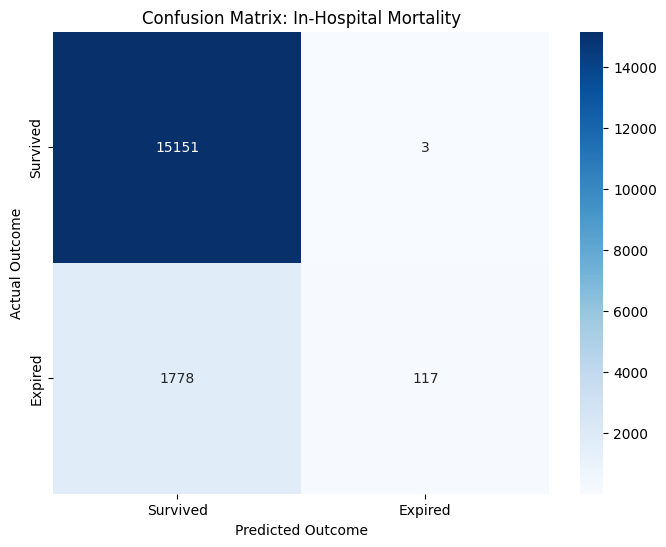

Final Test AUC-ROC: 0.8672


In [55]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Generate Predictions
# model.predict returns probabilities (0.0 to 1.0) due to the Sigmoid layer
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.9).astype(int)

# 2. Classification Report
print("--- Classification Report ---")
# This gives us Precision, Recall, and F1-score for both classes
print(classification_report(y_test, y_pred_classes, target_names=['Survived', 'Expired']))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survived', 'Expired'],
            yticklabels=['Survived', 'Expired'])
plt.title('Confusion Matrix: In-Hospital Mortality')
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

# 4. Final AUC Score
auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test AUC-ROC: {auc_score:.4f}")

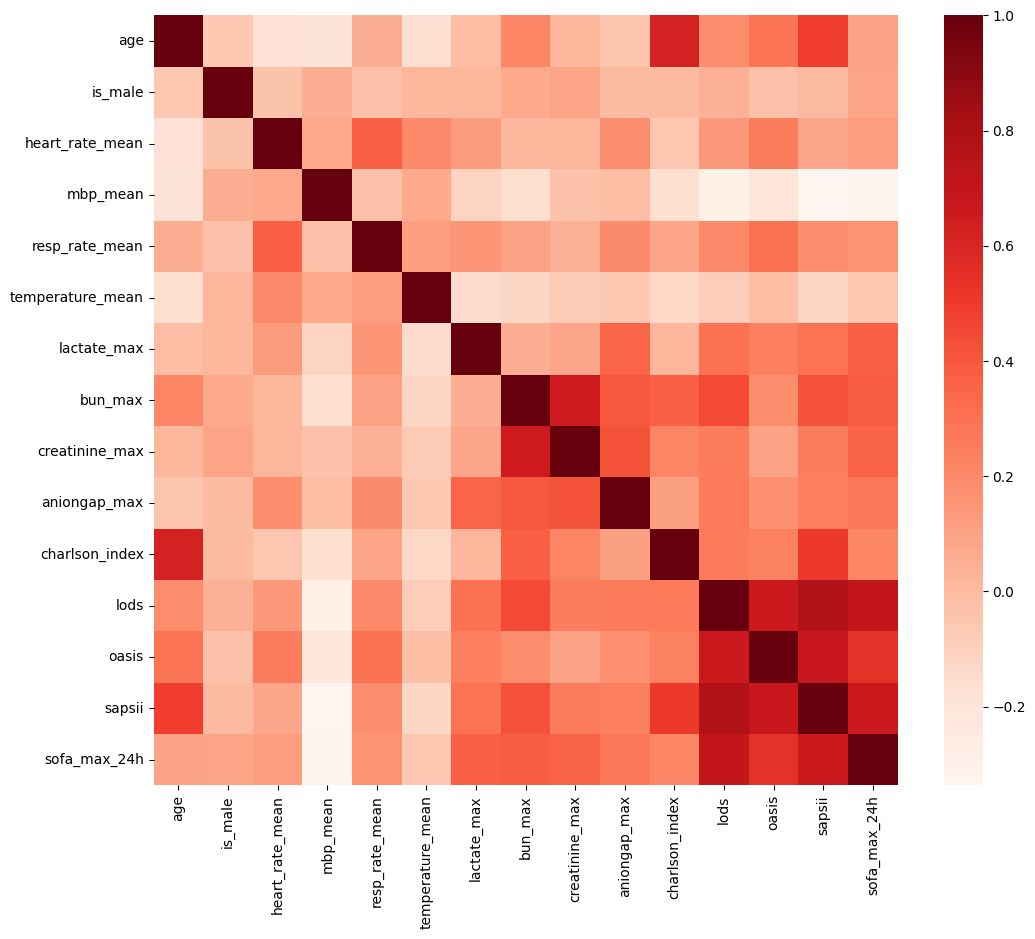

In [56]:
import seaborn as sns

plt.figure(figsize=(12,10))
cor = df[feature_cols].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

In [12]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Use a tree-based model to pick the best 10 features
selector = RFE(RandomForestClassifier(), n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

# View selected features
selected_features = [f for f, s in zip(feature_cols, selector.support_) if s]
print(f"Top 10 Features: {selected_features}")

Top 10 Features: ['age', 'heart_rate_mean', 'mbp_mean', 'resp_rate_mean', 'temperature_mean', 'bun_max', 'lods', 'oasis', 'sapsii', 'sofa_max_24h']


In [14]:
df2 = df[['subject_id'] + selected_features + ['label']]
# 1. DEFINE GROUPS AND FEATURES
groups = df['subject_id']
y = df2['label']
X = df2.drop(columns=['label'])

# 2. PATIENT-AWARE SPLIT (80% Train, 20% Test)
# GroupShuffleSplit ensures the same subject_id never appears in both sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

df_train = df2.iloc[train_idx].copy()
df_test = df2.iloc[test_idx].copy()

# 3. FIT SCALER ON TRAIN ONLY (To avoid Data Leakage)
scaler = StandardScaler()

# Identify feature columns (exclude IDs and labels)
feature_cols = [c for c in df_train.columns if c not in ['label', 'subject_id', 'hadm_id', 'stay_id']]

# Fit and transform training data
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Transform test data using the parameters (mean/std) from the training set
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

print(f"Train patients: {df_train['subject_id'].nunique()}")
print(f"Test patients: {df_test['subject_id'].nunique()}")
print(f"Features: {feature_cols}")

Train patients: 52292
Test patients: 13074
Features: ['age', 'heart_rate_mean', 'mbp_mean', 'resp_rate_mean', 'temperature_mean', 'bun_max', 'lods', 'oasis', 'sapsii', 'sofa_max_24h']


In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 1. Convert DataFrames to Tensors
# Assuming df_train and df_test are from the previous step
X_train = df_train[feature_cols].values.astype('float32')
y_train = df_train['label'].values.astype('float32')

X_test = df_test[feature_cols].values.astype('float32')
y_test = df_test['label'].values.astype('float32')

# 2. Define the Model Architecture
model = models.Sequential([
    # Input Layer (number of features)
    layers.Input(shape=(X_train.shape[1],)),
    
    # Hidden Layer 1: Dense + BatchNormalization + Dropout
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.2), # Prevents overfitting
    
    # Hidden Layer 2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    
    # Output Layer: Sigmoid for binary probability (0 to 1)
    layers.Dense(1, activation='sigmoid')
])

# 3. Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'), # Best metric for imbalanced clinical data
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 4. Handle Class Imbalance
# Calculate weights so the model pays more attention to the minority (death) class
neg, pos = np.bincount(df_train['label'])
total = neg + pos
class_weight = {0: (1 / neg) * (total / 2.0), 1: (1 / pos) * (total / 2.0)}

# 5. Training with Early Stopping
# Stop training if validation AUC stops improving to prevent overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_auc', 
    patience=8, 
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1, # Uses 10% of train for real-time monitoring
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

# 6. Evaluate on Final Test Set
results = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest AUC: {results[2]:.4f}")

Epoch 1/100
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 2s 720us/step - accuracy: 0.6681 - auc: 0.7840 - loss: 0.5648 - precision: 0.2170 - recall: 0.7502 - val_accuracy: 0.7624 - val_auc: 0.8586 - val_loss: 0.4809 - val_precision: 0.2806 - val_recall: 0.7795
Epoch 2/100
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - accuracy: 0.7529 - auc: 0.8388 - loss: 0.4980 - precision: 0.2793 - recall: 0.7595 - val_accuracy: 0.7828 - val_auc: 0.8675 - val_loss: 0.4581 - val_precision: 0.3043 - val_recall: 0.8000
Epoch 3/100
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - accuracy: 0.7609 - auc: 0.8448 - loss: 0.4895 - precision: 0.2872 - recall: 0.7624 - val_accuracy: 0.7837 - val_auc: 0.8705 - val_loss: 0.4531 - val_precision: 0.3057 - val_recall: 0.8027
Epoch 4/100
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - accuracy: 0.7637 - auc: 0.8494 - loss: 0.4832 - precision: 0.2907 - recall: 0.7669 - val_accuracy: 0.7913 - val_auc: 0.8729 - val_loss: 0.4428 - val_precision: 0.3136 - val_recall: 0.7986
Epoch 5/100


533/533 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
--- Classification Report ---
              precision    recall  f1-score   support

    Survived       0.91      0.99      0.95     15154
     Expired       0.79      0.20      0.32      1895

    accuracy                           0.91     17049
   macro avg       0.85      0.60      0.64     17049
weighted avg       0.90      0.91      0.88     17049



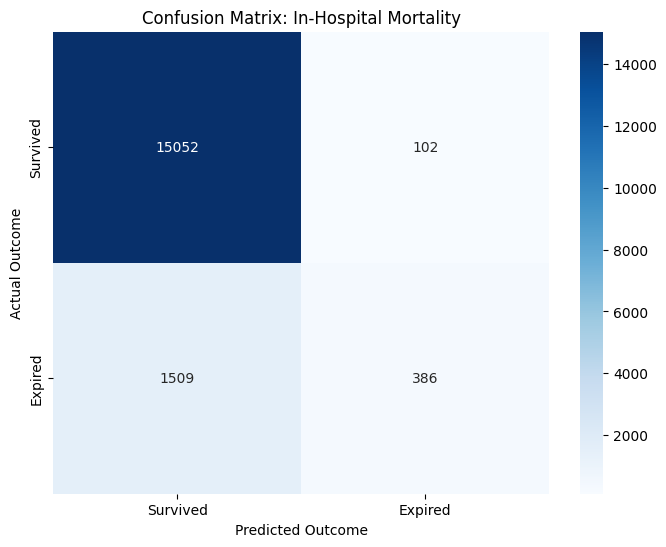

Final Test AUC-ROC: 0.8672


In [57]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Generate Predictions
# model.predict returns probabilities (0.0 to 1.0) due to the Sigmoid layer
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.6).astype(int)

# 2. Classification Report
print("--- Classification Report ---")
# This gives us Precision, Recall, and F1-score for both classes
print(classification_report(y_test, y_pred_classes, target_names=['Survived', 'Expired']))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survived', 'Expired'],
            yticklabels=['Survived', 'Expired'])
plt.title('Confusion Matrix: In-Hospital Mortality')
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

# 4. Final AUC Score
auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test AUC-ROC: {auc_score:.4f}")